In [1]:
import SimpleITK as sitk
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from ipywidgets import interact
from ipywidgets.widgets import IntSlider
import cv2
import ants as ants
import matplotlib.pyplot as plt
import pydicom
from matplotlib.colors import ListedColormap
import os
from scipy import ndimage
import ImageTool.tool as tool
import PerfusionImaging.tool as perfusion
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import pandas as pd

2025-03-12 14:10:40.943706: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 14:10:40.951247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-12 14:10:40.961999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-12 14:10:40.962038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 14:10:40.969903: I tensorflow/core/platform/cpu_feature_gua

In [2]:
target = "08_22_22_data/Pig1"
rest_sample = "Acq_02_Baseline"
stress_sample = "Acq_03_Stress"
save_path = os.path.join("/home/molloi-lab-linux2/smb_mount/ImageData/Myocardial_Perfusion/High_Fat_Diet/QYZ", target)
path_rest = os.path.join(save_path, rest_sample, "DICOM/02")
path_stress = os.path.join(save_path, stress_sample, "DICOM/02")
lmmask_path_rest = os.path.join(save_path, rest_sample, "SEGMENT_dcm/LEFT_MYOCARDIUM_dcm")
lmmask_path_stress = os.path.join(save_path, stress_sample, "SEGMENT_dcm/LEFT_MYOCARDIUM_dcm")
aorta_rest_mask = os.path.join(save_path, rest_sample, "SEGMENT_dcm/AORTA_dcm")
aorta_stress_mask = os.path.join(save_path, stress_sample, "SEGMENT_dcm/AORTA_dcm")
bolus_rest = os.path.join(save_path, rest_sample, "SureStart")
bolus_stress = os.path.join(save_path, stress_sample, "SureStart")

In [3]:
mask_rest_left = tool.load_2d_3d(lmmask_path_rest) 
mask_rest_right = tool.load_2d_3d(lmmask_path_rest.replace("LEFT", "RIGHT")) 
full_rest_mask = perfusion.mask_fun(sitk.GetArrayFromImage(mask_rest_left)) | perfusion.mask_fun(sitk.GetArrayFromImage(mask_rest_right))
full_rest_image = sitk.GetImageFromArray(full_rest_mask)
full_rest_image.CopyInformation(mask_rest_left)

mask_stress_left = tool.load_2d_3d(lmmask_path_stress) 
mask_stress_right = tool.load_2d_3d(lmmask_path_stress.replace("LEFT", "RIGHT")) 
full_stress_mask = perfusion.mask_fun(sitk.GetArrayFromImage(mask_stress_left)) | perfusion.mask_fun(sitk.GetArrayFromImage(mask_stress_right))
full_stress_image = sitk.GetImageFromArray(full_stress_mask)
full_stress_image.CopyInformation(mask_stress_left)


In [4]:
save_files = os.path.join("/home/molloi-lab-linux2/Desktop/ZQY/Project perfusion/Alireza", target)
tool.make_if_dont_exist(save_files)
tool.load_2d_3d(path_rest, save_files + "/rest.nii")
tool.load_2d_3d(path_stress, save_files + "/stress.nii")
sitk.WriteImage(full_rest_image, save_files + "/full_rest_mask.nii")
sitk.WriteImage(full_stress_image, save_files + "/full_stress_mask.nii")
tool.load_2d_3d(aorta_rest_mask, save_files + "/aorta_rest.nii")
tool.load_2d_3d(aorta_stress_mask, save_files + "/aorta_stress.nii")
tool.load_2d_3d(bolus_rest, save_files + "/bolus_rest.nii")
tool.load_2d_3d(bolus_stress, save_files + "/bolus_stress.nii")


<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7f06d12f4f00> >

In [5]:
dcm_stress = ants.image_read(save_files + "/stress.nii")
dcm_rest = ants.image_read(save_files + "/rest.nii")
dcm_mask_rest = ants.image_read(save_files + "/full_rest_mask.nii")
dcm_mask_stress = ants.image_read(save_files + "/full_stress_mask.nii") 
dcm_rest_aorta = ants.image_read(save_files + "/aorta_rest.nii") 
dcm_stress_aorta = ants.image_read(save_files + "/aorta_stress.nii") 

In [6]:
rest_value = np.sum(dcm_rest[:] * perfusion.mask_fun(dcm_rest_aorta[:]))/np.sum(perfusion.mask_fun(dcm_rest_aorta[:]))
stress_value = np.sum(dcm_stress[:] * perfusion.mask_fun(dcm_stress_aorta[:]))/np.sum(perfusion.mask_fun(dcm_stress_aorta[:]))
np.save(save_files + "/value.npy", np.array([rest_value, stress_value]))

In [37]:
%matplotlib inline
def plot_slice1(slice_index):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(dcm_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=500)
    ax1.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha= 0.5)
    # ax1.imshow(dcm_rest_aorta[:, :, slice_index], cmap=ListedColormap(['black', 'green']),  vmin=0, vmax=1, alpha = 0.7)

    ax2.imshow(dcm_stress[:, :, slice_index], cmap='gray', vmin=0, vmax=500)
    ax2.imshow(dcm_mask_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha= 0.5)
    ax2.set_title("reg_stress scan")

# Creating an interactive slider
interact(plot_slice1, slice_index=IntSlider(min=0, max=dcm_mask_rest.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice1(slice_index)>

In [8]:
def get_mask_img(img, mask):
    # Ensure img is a NumPy array
    fix_array = np.array(img[:], copy=True)

    # Apply the mask (only modify valid data)
    fix_array[mask[:] == 0] = 0  

    # Convert to ANTsImage
    fix_img = ants.from_numpy(fix_array)

    # Preserve original metadata (spacing, origin, direction)
    fix_img.set_spacing(img.spacing)
    fix_img.set_origin(img.origin)
    fix_img.set_direction(img.direction)

    return fix_img



In [9]:

method = ants.registration(fixed=get_mask_img(dcm_rest, dcm_mask_rest) , moving=get_mask_img(dcm_stress, dcm_mask_stress), type_of_transform ='SyNAggro')
reg_stress = ants.apply_transforms(fixed=dcm_rest, moving=dcm_stress, transformlist=method['fwdtransforms'])
# reg_stress = ants.registration(fixed=dcm_rest, moving=dcm_stress, moving_mask = dcm_lmmask_stress, mask = dcm_lmmask_rest, type_of_transform ='SyNAggro')["warpedmovout"].numpy()

In [10]:
%matplotlib inline
def plot_slice2(slice_index):
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 6))
    current_slice_index = slice_index  # Update the global variable
    pcm = ax1.imshow(dcm_mask_stress[:, :, slice_index], cmap=ListedColormap(['black', 'green']),  vmin=0, vmax=1, alpha = 1)
    ax1.imshow(dcm_mask_rest[: , :, slice_index], cmap='jet', vmin=0, vmax=1, alpha = 0.5)
    ax1.set_title("rest scan")
    pcm3 = ax3.imshow(method["warpedmovout"][:, :, slice_index], cmap=ListedColormap(['black', 'green']), vmin=0, vmax=1)
    ax3.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha = 0.5)
    ax3.set_title("dcm_stress")
    plt.show()

# Creating an interactive slider
interact(plot_slice2, slice_index=IntSlider(min=0, max=dcm_mask_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice2(slice_index)>

In [39]:
def plot_slice3(slice_index):
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 5))
    pcm = ax0.imshow(abs(reg_stress[:, :, slice_index] - dcm_rest[:, :, slice_index]), cmap='jet', vmin=0, vmax=500)
    ax0.set_title("rest")

    pcm = ax1.imshow(dcm_rest[:, :, slice_index] * dcm_mask_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=500)
    ax1.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0)
    ax1.set_title("Rest")
    pcm2 = ax2.imshow(reg_stress[:, :, slice_index], cmap='gray', vmin=0, vmax=500)
    ax2.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0.5)
    ax2.set_title("Register")
    pcm3 = ax3.imshow(dcm_stress[:, :, slice_index], cmap='gray', vmin=0, vmax=500)
    ax3.imshow(dcm_mask_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0.5)
    ax3.set_title("Stress")
    
    ax4.imshow(dcm_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=500)
    ax4.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha= 0.5)

    # ax1.imshow(dcm_rest_aorta[:, :, slice_index], cmap=ListedColormap(['black', 'green']),  vmin=0, vmax=1, alpha = 0.7)


    plt.show()

# Creating an interactive slider
interact(plot_slice3, slice_index=IntSlider(min=0, max=reg_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice3(slice_index)>

In [12]:
ants.image_write(reg_stress, save_files + "/reg_stress.nii")

In [13]:
time_v2 = perfusion.scan_time_vector([os.path.join(path_rest, i) for i in os.listdir(path_rest)])
time_ss = perfusion.scan_time_vector([os.path.join(bolus_rest, i) for i in os.listdir(bolus_rest)])
time_vec_gamma_rest = time_ss + [time_v2[len(time_v2)//2]]
time_vec_gamma_rest = [i - time_vec_gamma_rest[0] for i in time_vec_gamma_rest]

time_v2 = perfusion.scan_time_vector([os.path.join(path_stress, i) for i in os.listdir(path_stress)])
time_ss = perfusion.scan_time_vector([os.path.join(bolus_stress, i) for i in os.listdir(bolus_stress)])
time_vec_gamma_stress = time_ss + [time_v2[len(time_v2)//2]]
time_vec_gamma_stress = [i - time_vec_gamma_stress[0] for i in time_vec_gamma_stress]

In [14]:
ss_rest = ants.image_read(save_files + "/bolus_rest.nii")[:]
first_slice_rest = ants.image_read(save_files + "/bolus_rest.nii")[:,:,0]
ss_stress = ants.image_read(save_files + "/bolus_stress.nii")[:]
first_slice_stress = ants.image_read(save_files + "/bolus_rest.nii")[:,:,0]
ss_rest_value = [0] * (ss_rest.shape[0] + 1)
ss_rest_value[-1] = np.load(save_files + "/value.npy")[0]
ss_stress_value = [0] * (ss_stress.shape[0] + 1)
ss_stress_value[-1] = np.load(save_files + "/value.npy")[1]
input_conc = [0, 0]
auc_area = [0, 0]

In [16]:
%matplotlib inline
def plot_slice4(slice_index, x, y, r):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

    pcm = ax0.imshow(ss_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=300)
    ax0.set_title("rest")
    phi = np.linspace(0, 2 * np.pi, 100)
    circle_x = r * np.cos(phi) + x
    circle_y = r * np.sin(phi) + y
    ax0.plot(circle_x, circle_y, label=f"Aorta Mask (radius {r})", color="red", linewidth=1)
    ss_rest_value[:-1] = perfusion.compute_aif(ss_rest, x, y, r)
    # Add legend
    ax0.legend()
    np.save("rest_para_cfr.npy", [x, y, r])

    
    try:
        input_conc[0], _ = perfusion.gamma_plot(ax1, time_vec_gamma_rest, ss_rest_value, triger=False)
    except:
        pass
    # Show the plot
    plt.show()

# Creating an interactive slider
if os.path.exists("rest_para_cfr.npy"):
    x, y, r = np.load("rest_para_cfr.npy")
else:
    x, y, r = 0, 0, 8
interact(plot_slice4, slice_index=IntSlider(max=ss_rest.shape[2] - 1), x = IntSlider(min = 15, max = ss_rest.shape[0] - 15, value = x), y = IntSlider(min = 15, max = ss_rest.shape[1] - 15, value = y), r = IntSlider(max = 14, value = r))

interactive(children=(IntSlider(value=0, description='slice_index', max=18), IntSlider(value=209, description=…

<function __main__.plot_slice4(slice_index, x, y, r)>

The slice number of 181 is chosen
65.04909 90.66102


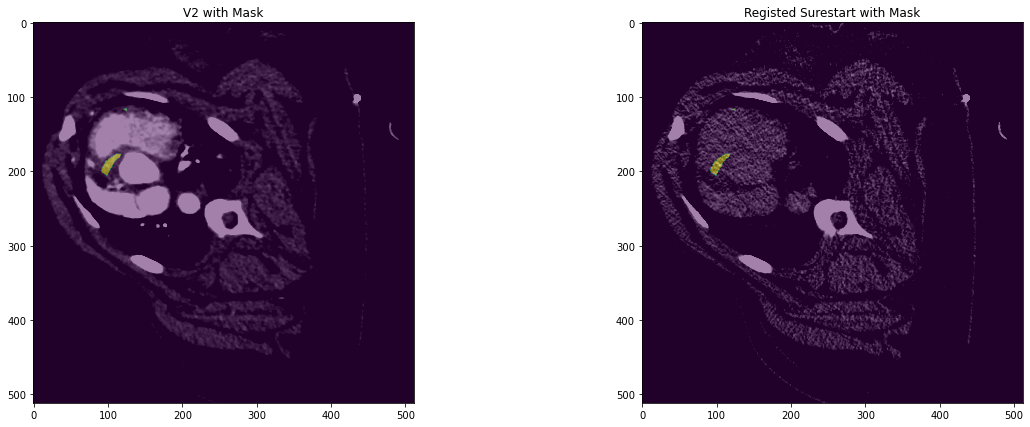

In [17]:
HU_sure_mean = perfusion.calculate_mean_hu(dcm_rest, dcm_mask_rest, first_slice_rest, erode_size = 2, visual=True)
# HU_sure_mean = 69
print(HU_sure_mean, np.mean(dcm_rest[dcm_mask_rest]))

In [18]:
result_rest = perfusion.compute_organ_metrics(dcm_rest, dcm_mask_rest, HU_sure_mean, input_conc[0], tissue_rho=1.053)

In [19]:
col_vals = [result_rest["perf"], result_rest["perf_std"], result_rest["flow"], result_rest["flow_std"], result_rest["organ_mass"]]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "mass"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
np.save(save_files + '/rest_result.npy', df.to_numpy())
df

,parameters,values
0,perfusion,0.851645
1,perfusion_std,1.367810
2,flow,25.698772
3,flow_std,41.274315
4,mass,30.175465


In [20]:
%matplotlib inline
def plot_slice5(slice_index, x, y, r):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

    # plt.figure(figsize=(5, 5))
    pcm = ax0.imshow(ss_stress[:, :, slice_index], cmap='gray', vmin=0, vmax=300)
    ax0.set_title("stress")
    phi = np.linspace(0, 2 * np.pi, 100)
    circle_x = r * np.cos(phi) + x
    circle_y = r * np.sin(phi) + y
    ax0.plot(circle_x, circle_y, label=f"Aorta Mask (radius {r})", color="red", linewidth=1)
    ss_stress_value[:-1] = perfusion.compute_aif(ss_stress, x, y, r)
    # Add legend
    ax0.legend()
    try:
        input_conc[1], _ = perfusion.gamma_plot(ax1, time_vec_gamma_stress, ss_stress_value, triger=False)

        np.save("stress_para.npy", [x, y, r])
    except:
        pass
    # Show the plot
    plt.show()

# Creating an interactive slider
if os.path.exists("stress_para.npy"):
    x, y, r = np.load("stress_para.npy")
else:
    x, y, r = 0, 0, 8
interact(plot_slice5, slice_index=IntSlider(max=ss_stress.shape[2] - 1), x = IntSlider(min = 15, max = ss_stress.shape[0] - 15, value = x), y = IntSlider(min = 15, max = ss_stress.shape[1] - 15, value = y), r = IntSlider(max = 14, value = r))

interactive(children=(IntSlider(value=0, description='slice_index', max=20), IntSlider(value=212, description=…

<function __main__.plot_slice5(slice_index, x, y, r)>

The slice number of 185 is chosen
65.83657 123.1828


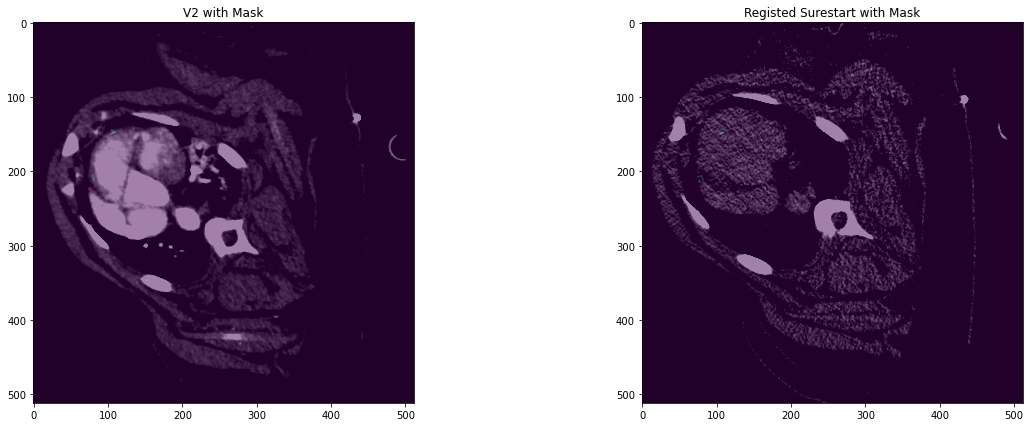

In [21]:
HU_sure_mean_stress = perfusion.calculate_mean_hu(dcm_stress, dcm_mask_stress, first_slice_stress, erode_size = 2, visual = True)
# HU_sure_mean_stress = 88
print(HU_sure_mean_stress, np.mean(reg_stress[dcm_mask_rest]))

In [22]:
result_stress = perfusion.compute_organ_metrics(reg_stress, dcm_mask_rest, HU_sure_mean_stress, input_conc[1], tissue_rho=1.053)

In [23]:
col_vals = [result_stress["perf"], result_stress["perf_std"], result_stress["flow"], result_stress["flow_std"],  result_stress["organ_mass"]]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "mass"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
# Save the NumPy array to a .npy file
np.save(save_files + '/stress_result.npy', df.to_numpy())
df

,parameters,values
0,perfusion,2.156117
1,perfusion_std,1.105917
2,flow,65.061841
3,flow_std,33.371578
4,mass,30.175465


In [24]:
CFR = result_stress["perf"]/result_rest["perf"]
# result_stress["perf_map"][~dcm_mask_rest[:].astype(bool)] = np.nan
# result_rest["perf_map"][~dcm_mask_rest[:].astype(bool)] = np.nan
CFR

2.5317100670024795

The labels order will be: ['Normal Flow', 'Minimally Reduced', 'Mildly Reduced', 'Moderately Reduced Flow Capacity', 'Myocardial Steal', 'Definite Ischemia', 'Predominantly Transmural Myocardial Scar']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 713.44it/s]


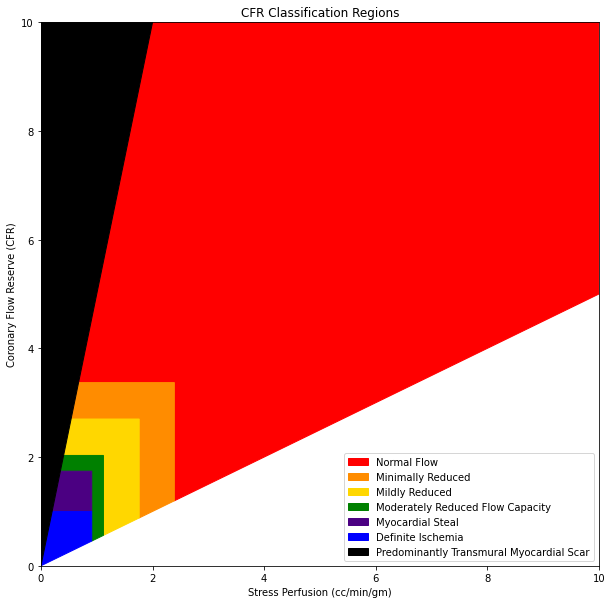

In [25]:
CFC, _ = perfusion.classify_CFR_region([CFR], [result_stress["perf"]], visualization=True)

In [26]:
rest_perf = result_rest["perf_map"].copy()
# rest_perf[rest_perf <= 0] = np.nan
CFR_map = result_stress["perf_map"]/rest_perf
CFR_map[CFR_map > 10] = 10

In [43]:
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
def classify_CFR_region(stress_values, cfr_values, visualization=False, sample_rate = 1):
    labels = ["Normal Flow", "Minimally Reduced", "Mildly Reduced", 
              "Moderately Reduced Flow Capacity", "Myocardial Steal", 
              "Definite Ischemia", "Predominantly Transmural Myocardial Scar"]
    print("The labels order will be:", labels)
    colors = {
        "Normal Flow": "#FF0000",  # Brown
        "Minimally Reduced": "#FF8C00",  # Orange
        "Mildly Reduced": "#FFD700",  # Yellow
        "Moderately Reduced Flow Capacity": "#008000",  # Green
        "Definite Ischemia": "#0000FF",  # Blue
        "Myocardial Steal": "#4B0082",  # Dark Blue
        "Predominantly Transmural Myocardial Scar": "#000000"  # Black
    }
    
    # Define the CFR regions as polygons
    regions = {
        "Normal Flow": Polygon([(3.37/5, 3.37), (2.39, 3.37), (2.39, 2.39/2), (10, 5), (10, 10), (2, 10)]),
        "Minimally Reduced": Polygon([(1.76, 0.88), (1.76, 2.7), (0.54, 2.7), (3.37/5, 3.37), (2.39, 3.37), (2.39, 2.39/2)]),
        "Mildly Reduced": Polygon([(0.406, 2.03), (1.12, 2.03), (1.12, 0.56), (1.76, 0.88), (1.76, 2.7), (0.54, 2.7)]),
        "Moderately Reduced Flow Capacity": Polygon([(1.74/5, 1.74), (0.91, 1.74), (0.91, 0.91/2), (1.12, 0.56), (1.12, 2.03), (0.406, 2.03)]),
        "Myocardial Steal": Polygon([(1/5, 1), (1.74/5, 1.74), (0.91, 1.74), (0.91, 1)]),
        "Definite Ischemia": Polygon([(0, 0), (1/5, 1), (0.91, 1), (0.91, 0.91/2)]),
        "Predominantly Transmural Myocardial Scar": Polygon([(0, 0), (2, 10), (0, 10)]),
    }

    # Ensure inputs are NumPy arrays and handle 3D arrays
    stress_values = np.array(stress_values)
    cfr_values = np.array(cfr_values)

    # Validate input shapes
    if stress_values.shape != cfr_values.shape:
        raise ValueError("stress_values and cfr_values must have the same shape")

    # Initialize 3D arrays for labels and indices
    label_names = np.empty(stress_values.shape, dtype=object)
    label_indices = stress_values.copy()
    valid_indices = np.argwhere(~np.isnan(stress_values) & ~np.isnan(cfr_values))

    # Iterate only over valid indices
    
    # Iterate over each voxel in the 3D arrays
    if visualization:
        fig, ax = plt.subplots(figsize=(10, 10))
        for label, polygon in regions.items():
            x, y = polygon.exterior.xy  # Get polygon boundary coordinates
            ax.fill(x, y, alpha=1, label=label, color=colors[label])
            
    for i in tqdm(range(len(valid_indices))):
        idx = tuple(valid_indices[i])  # Convert index array to tuple for proper indexing
        stress = stress_values[idx]
        cfr = cfr_values[idx]
        point = Point(stress, cfr)  # Create a point object

        # Check if the point is inside any region
        min_distance = float("inf")
        closest_region = "Outside Defined Regions"
        closest_index = -1

        for label, polygon in regions.items():
            if polygon.contains(point):
                label_names[idx] = label
                label_indices[idx] = labels.index(label)
                break  # Stop checking if a match is found
            else:
                # Compute distance from point to polygon
                distance = polygon.exterior.distance(point)
                if distance < min_distance:
                    min_distance = distance
                    closest_region = label
                    closest_index = labels.index(label)
        else:
            label_names[idx] = closest_region  # Assign the closest region
            label_indices[idx] = closest_index
        if visualization and i % sample_rate == 0:
            ax.scatter(stress, cfr, color='gray', marker='o', s=10)

    # Complete visualization setup
    if visualization:
        ax.set_xlabel("Stress Perfusion (cc/min/gm)")
        ax.set_ylabel("Coronary Flow Reserve (CFR)")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.legend(loc="lower right")  # Move legend to lower-left corner
        ax.set_title("CFR Classification Regions")
        plt.show()
    return label_indices, label_names

The labels order will be: ['Normal Flow', 'Minimally Reduced', 'Mildly Reduced', 'Moderately Reduced Flow Capacity', 'Myocardial Steal', 'Definite Ischemia', 'Predominantly Transmural Myocardial Scar']


100%|██████████| 261676/261676 [00:16<00:00, 16317.17it/s]


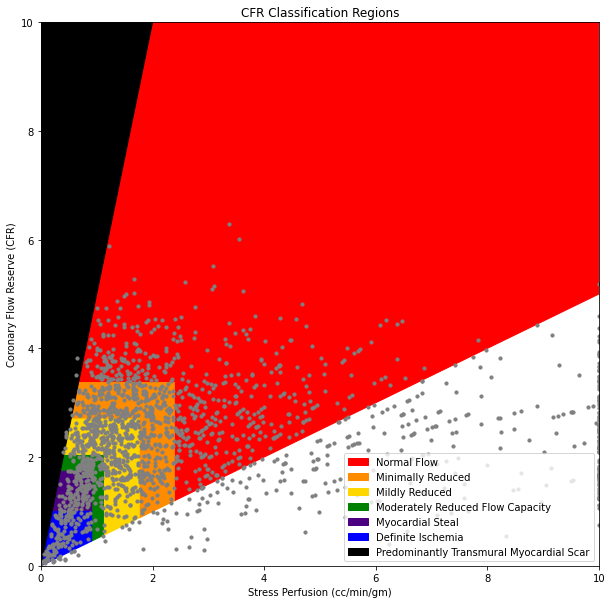

In [44]:
CFC_map, _ = classify_CFR_region(CFR_map, result_stress["perf_map"], visualization=True, sample_rate=100)

In [45]:
%matplotlib inline
new_cfr_map = CFR_map.copy()
# new_cfr_map[~full_rest_mask[:].astype(bool)] = 100
def plot_slice7(slice_index):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
    

    ax1.imshow(new_cfr_map[:, :, slice_index], cmap='jet', vmin=0, vmax=1)
    ax1.set_title("cfr scan")
    
    pcm2 = ax2.imshow(result_stress["perf_map"][:, :, slice_index], cmap='jet', vmin=0, vmax=3)
    ax2.set_title("perfusion_stress scan")
    
    pcm3 = ax3.imshow(result_rest["perf_map"][:, :, slice_index], cmap='jet', vmin=0, vmax=3)
    ax3.set_title("perfusion_rest")
    
    pcm4 = ax4.imshow(CFC_map[:, :, slice_index], cmap='jet', vmin=0, vmax=7)
    ax4.set_title("CFC")
# Creating an interactive slider
interact(plot_slice7, slice_index=IntSlider(min=0, max=dcm_mask_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice7(slice_index)>

In [46]:
mask = tool.erode3d(perfusion.mask_fun(tool.sitk2ant(mask_rest_left)[:]), size = 0).astype(bool) #tool.erode3d(perfusion.mask_fun(tool.sitk2ant(mask_rest_right)[:]), size = 1).astype(bool)  | 

File tmp.nii has been deleted.


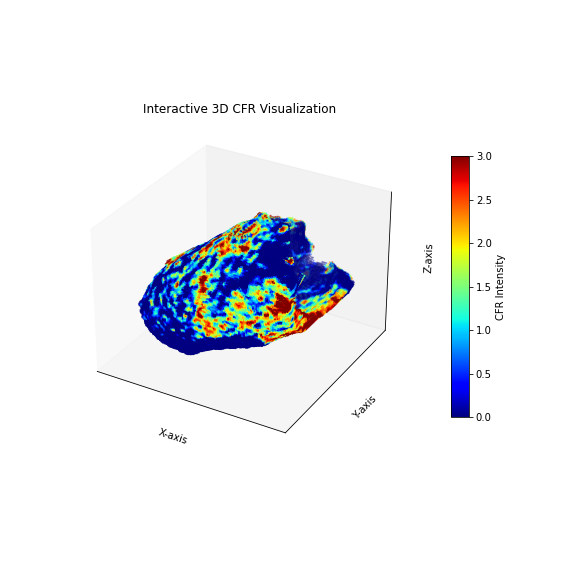

In [47]:
%matplotlib notebook
tool.plot3d(result_rest["perf_map"], mask.astype(int), sample_rate=1, vmax = 3)

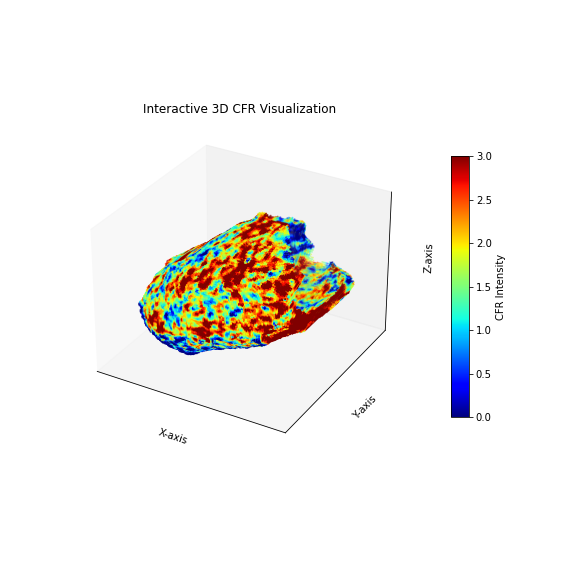

In [48]:
%matplotlib notebook
tool.plot3d(result_stress["perf_map"], mask.astype(int), sample_rate=1, vmax = 3)

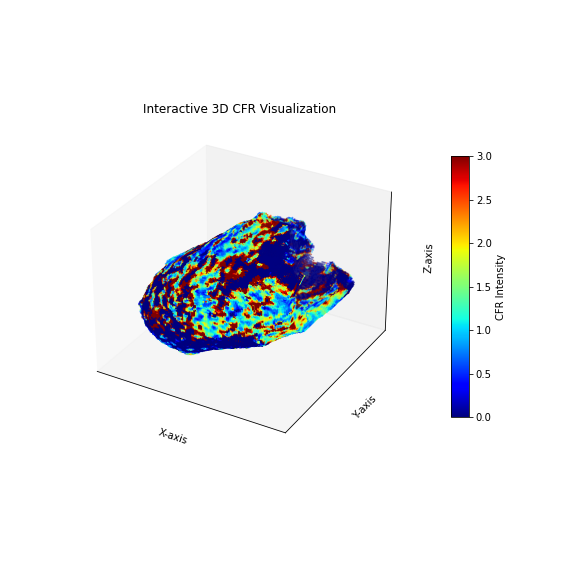

In [49]:
%matplotlib notebook
tool.plot3d(CFR_map, mask.astype(int), sample_rate=1, vmax = 3)

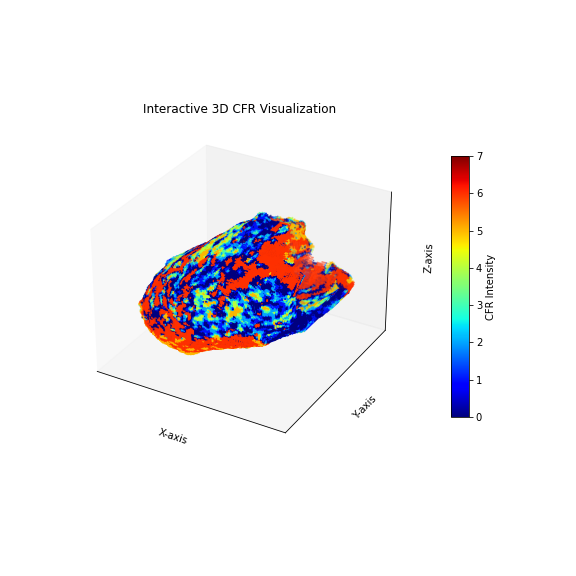

In [50]:
%matplotlib notebook
tool.plot3d(CFC_map, mask.astype(int), sample_rate=1, vmax = 7)

In [31]:
CFR_map_new = CFR_map.copy()
CFR_map_new[CFR_map_new > 10] = 10
CFR_map_new[CFR_map_new > 10]
CFR_map_new = ants.from_numpy(CFR_map_new, origin=dcm_mask_rest.origin, spacing=dcm_mask_rest.spacing, direction=dcm_mask_rest.direction)
pref_rest_new = ants.from_numpy(result_rest["perf_map"], origin=dcm_mask_rest.origin, spacing=dcm_mask_rest.spacing, direction=dcm_mask_rest.direction)
pref_stress_new = ants.from_numpy(result_stress["perf_map"], origin=dcm_mask_rest.origin, spacing=dcm_mask_rest.spacing, direction=dcm_mask_rest.direction)
# Step 3: Save the new image with updated metadata
ants.image_write(CFR_map_new, save_files + "/CFR_with_headers.nii")
ants.image_write(pref_rest_new, save_files + "/pref_rest.nii")
ants.image_write(pref_stress_new, save_files + "/pref_stress.nii")